## Setup Env

In [1]:
!pip install yolov5 pycocotools tqdm roboflow pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 2.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.7/463.7 kB 4.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━

In [1]:
import yolov5
display = yolov5.utils.notebook_init()  # checks

initialization = False  # set to True if you need to download the dataset and preprocessing

YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)


Setup complete ✅ (12 CPUs, 31.2 GB RAM, 50.1/139.7 GB disk)


## Preprocessing

### Download Data

In [2]:
if initialization:
    from roboflow import Roboflow
    
    
    rf = Roboflow(api_key="ZNySpkMbH4D16UY4lxCs")
    project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
    dataset = project.version(3).download("yolov5")

### Read Data

In [3]:
import os
import yaml
try:
  from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
  from yaml import Loader, Dumper

with open('Self-Driving-Car-3/data.yaml') as f:
  data_meta = yaml.load(f.read(), Loader=Loader)
data_meta

{'names': ['biker',
  'car',
  'pedestrian',
  'trafficLight',
  'trafficLight-Green',
  'trafficLight-GreenLeft',
  'trafficLight-Red',
  'trafficLight-RedLeft',
  'trafficLight-Yellow',
  'trafficLight-YellowLeft',
  'truck'],
 'nc': 11,
 'roboflow': {'license': 'MIT',
  'project': 'self-driving-car',
  'url': 'https://universe.roboflow.com/roboflow-gw7yv/self-driving-car/dataset/3',
  'version': 3,
  'workspace': 'roboflow-gw7yv'},
 'test': '../test/images',
 'train': 'Self-Driving-Car-3/train/images',
 'val': 'Self-Driving-Car-3/valid/images'}

In [5]:
path_images = os.path.join('Self-Driving-Car-3', 'export', 'images')
path_labels = os.path.join('Self-Driving-Car-3', 'export', 'labels')
print(len(os.listdir(path_images)), len(os.listdir(path_labels)))

29800 29800


In [4]:
if initialization:
    os.listdir(path_images)[-1]

In [5]:
if initialization:
    path_0 = os.listdir(path_labels)[30]
    path_0

In [6]:
if initialization:
    with open(os.path.join(path_labels, path_0)) as f:
      label_0 = f.read()
    print(label_0)

In [7]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


if initialization:
    LABELS = os.listdir(path_labels)
    
    
    def show_image(ind):
      pth = LABELS[ind]
      with open(os.path.join(path_labels, pth)) as f:
        label = f.read()
      img = Image.open(os.path.join(
          path_images, os.path.splitext(pth)[0] + '.jpg'))
      print(f'{img.size=}')
      width, height = img.size
    
      plt.imshow(img)
      for line in label.split('\n'):
        cx, cy, w, h = map(float, line.split(' ')[1:])
        cx *= width
        cy *= height
        w *= width
        h *= height
        x = cx - w / 2
        y = cy - h / 2
        coor = [(x, y), (x + w, y), (x + w, y + h), (x, y + h), (x, y)]
        coor = np.array(coor)
        plt.plot(*coor.T)
      print(label)
    
    
    show_image(30)

### Train-Text-Valid Split

In [8]:
import shutil
import random
from tqdm import tqdm

if initialization:
    def split_train_text_valid(labels, ratios=[0.7, 0.2, 0.1], path=''):
      labels = list(set(labels))
      random.shuffle(labels)
      cut_1, cut_2 = ratios[:2]
      cut_2 += cut_1
      cut_1 = int(len(labels) * cut_1)
      cut_2 = int(len(labels) * cut_2)
      train = labels[:cut_1]
      test = labels[cut_1: cut_2]
      valid = labels[cut_2:]
    
      for name, dataset in zip(['train', 'test', 'valid'], [train, test, valid]):
        pth_lab = os.path.join(path, name, 'labels')
        pth_img = os.path.join(path, name, 'images')
        try:
          shutil.rmtree(pth_lab)
        except:
          pass
        try:
          shutil.rmtree(pth_img)
        except:
          pass
        os.makedirs(pth_lab, exist_ok=True)
        os.makedirs(pth_img, exist_ok=True)
    
    
        for lab in tqdm(dataset):
          img = os.path.splitext(lab)[0] + '.jpg'
          shutil.copyfile(os.path.join(path_images, img),
                          os.path.join(pth_img, img))
          shutil.copyfile(os.path.join(path_labels, lab),
                          os.path.join(pth_lab, lab))
    
    
    split_train_text_valid(LABELS)

In [9]:
print(f'{len(os.listdir("train/images"))=}')
print(f'{len(os.listdir("test/images"))=}')
print(f'{len(os.listdir("valid/images"))=}')

len(os.listdir("train/images"))=20860
len(os.listdir("test/images"))=5959
len(os.listdir("valid/images"))=2981


In [10]:
data_meta['path'] = os.path.abspath('')
data_meta['train'] = 'train/images'
data_meta['val'] = 'valid/images'
data_meta['test'] = 'test/images'
data_meta

{'names': ['biker',
  'car',
  'pedestrian',
  'trafficLight',
  'trafficLight-Green',
  'trafficLight-GreenLeft',
  'trafficLight-Red',
  'trafficLight-RedLeft',
  'trafficLight-Yellow',
  'trafficLight-YellowLeft',
  'truck'],
 'nc': 11,
 'roboflow': {'license': 'MIT',
  'project': 'self-driving-car',
  'url': 'https://universe.roboflow.com/roboflow-gw7yv/self-driving-car/dataset/3',
  'version': 3,
  'workspace': 'roboflow-gw7yv'},
 'test': 'test/images',
 'train': 'train/images',
 'val': 'valid/images',
 'path': '/home/anthony/Documents/Homework Documents/Inno Lab 8'}

In [11]:
from yolov5.utils.general import check_dataset


data = check_dataset(data_meta)

## Model Training

### Setup model

In [12]:
# hyper-parameters
train_path, test_path, val_path = data["train"], data['test'], data["val"]
nc, names = len(data["names"]), data["names"]

hyp = {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0,
       'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0,
       'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0,
       'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0,
       'mixup': 0.0, 'copy_paste': 0.0}

cfg = {'nc': nc, 'depth_multiple': 0.33, 'width_multiple': 0.25,
       'anchors': [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]],
       'backbone': [[-1, 1, 'Conv', [64, 6, 2, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C3', [128]],
                    [-1, 1, 'Conv', [256, 3, 2]], [-1, 6, 'C3', [256]], [-1, 1, 'Conv', [512, 3, 2]],
                    [-1, 9, 'C3', [512]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 3, 'C3', [1024]],
                    [-1, 1, 'SPPF', [1024, 5]]],
       'head': [[-1, 1, 'Conv', [512, 1, 1]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
                [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [256, 1, 1]],
                [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]],
                [-1, 3, 'C3', [256, False]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 14], 1, 'Concat', [1]],
                [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 10], 1, 'Concat', [1]],
                [-1, 3, 'C3', [1024, False]], [[17, 20, 23], 1, 'Detect', ['nc', 'anchors']]]}

device = "cuda"
num_epochs = 1
batch_size = 64
img_size = 512

In [73]:
# set up model
import torch
from yolov5.utils.torch_utils import model_info
from yolov5.models.yolo import Model

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, pretrained=True).model
model = model.half().float()
model.hyp = hyp # attach hyperparameters to model
model.nc = nc  # attach number of classes to model
model.names = names  # attach class names to model
model.verbose = True
model_info(model)

Using cache found in /home/anthony/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)

YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [74]:
# check layers
for k, v in model.named_parameters():
    print(k)

model.0.conv.weight
model.0.bn.weight
model.0.bn.bias
model.1.conv.weight
model.1.bn.weight
model.1.bn.bias
model.2.cv1.conv.weight
model.2.cv1.bn.weight
model.2.cv1.bn.bias
model.2.cv2.conv.weight
model.2.cv2.bn.weight
model.2.cv2.bn.bias
model.2.cv3.conv.weight
model.2.cv3.bn.weight
model.2.cv3.bn.bias
model.2.m.0.cv1.conv.weight
model.2.m.0.cv1.bn.weight
model.2.m.0.cv1.bn.bias
model.2.m.0.cv2.conv.weight
model.2.m.0.cv2.bn.weight
model.2.m.0.cv2.bn.bias
model.3.conv.weight
model.3.bn.weight
model.3.bn.bias
model.4.cv1.conv.weight
model.4.cv1.bn.weight
model.4.cv1.bn.bias
model.4.cv2.conv.weight
model.4.cv2.bn.weight
model.4.cv2.bn.bias
model.4.cv3.conv.weight
model.4.cv3.bn.weight
model.4.cv3.bn.bias
model.4.m.0.cv1.conv.weight
model.4.m.0.cv1.bn.weight
model.4.m.0.cv1.bn.bias
model.4.m.0.cv2.conv.weight
model.4.m.0.cv2.bn.weight
model.4.m.0.cv2.bn.bias
model.4.m.1.cv1.conv.weight
model.4.m.1.cv1.bn.weight
model.4.m.1.cv1.bn.bias
model.4.m.1.cv2.conv.weight
model.4.m.1.cv2.bn.weigh

In [75]:
# frozee backbone
freeze_layers = [f'model.{x}.' for x in range(10)]
for k, v in model.named_parameters():
    v.requires_grad = True  # train all layers
    if any(x in k for x in freeze_layers):
        print(f'freezing {k}')
        v.requires_grad = False


freezing model.0.conv.weight
freezing model.0.bn.weight
freezing model.0.bn.bias
freezing model.1.conv.weight
freezing model.1.bn.weight
freezing model.1.bn.bias
freezing model.2.cv1.conv.weight
freezing model.2.cv1.bn.weight
freezing model.2.cv1.bn.bias
freezing model.2.cv2.conv.weight
freezing model.2.cv2.bn.weight
freezing model.2.cv2.bn.bias
freezing model.2.cv3.conv.weight
freezing model.2.cv3.bn.weight
freezing model.2.cv3.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
freezing model.3.conv.weight
freezing model.3.bn.weight
freezing model.3.bn.bias
freezing model.4.cv1.conv.weight
freezing model.4.cv1.bn.weight
freezing model.4.cv1.bn.bias
freezing model.4.cv2.conv.weight
freezing model.4.cv2.bn.weight
freezing model.4.cv2.bn.bias
freezing model.4.cv3.conv.weight
freezing model.4.cv3.bn.weight
freezing model.4.c

### Data Loader

In [85]:
# data loader
import numpy as np
from yolov5.utils.dataloaders import create_dataloader

train_loader, dataset = create_dataloader(
    train_path,
    img_size,
    batch_size,
    max(int(model.stride.max()), 32),
    hyp=hyp,
    augment=True,
    shuffle=True,
)

# test loader
test_loader, dataset = create_dataloader(
    test_path,
    img_size,
    batch_size,
    max(int(model.stride.max()), 32),
    hyp=hyp,
    augment=False,
    shuffle=False,
)

Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/train/labels.cach
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed
Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/test/labels.cache
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/test/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/test/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/D

In [77]:
# optimizer and loss
from yolov5.utils.torch_utils import smart_optimizer
from yolov5.utils.loss import ComputeLoss

optimizer = smart_optimizer(model)
compute_loss = ComputeLoss(model)  # Define loss function


optimizer: Adam(lr=0.001) with parameter groups 57 weight(decay=0.0), 60 weight(decay=1e-05), 60 bias


In [90]:
from math import inf
import numpy as np
from tqdm import tqdm
import torch


def train_model(model, loader, pbar=None):
    # training
    model.to(device)
    model.train()

    training_loss = []
    for (imgs, targets, paths, _) in loader:
        # Forward pass
        imgs = imgs.to(device).float() / 255
        pred = model(imgs)
        loss, loss_items = compute_loss(pred, targets.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss.append(loss.item())

        if pbar:
          pbar.set_postfix(loss=np.mean(training_loss))
    return np.mean(training_loss)


def test_model(model, loader, pbar=None):
  # testing
  with torch.no_grad():
    model.to(device)
    model.train()
    test_loss = []
    for (imgs, targets, paths, _) in loader:
      imgs = imgs.to(device).float() / 255
      pred = model(imgs)
      loss, loss_items = compute_loss(pred, targets.to(device))
      test_loss.append(loss.item())

      if pbar:
        pbar.set_postfix(test_loss=np.mean(test_loss))
    return np.mean(test_loss)


def train(model, train_loader, test_loader, num_epochs, best_loss=inf):
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description(f"Training [{epoch + 1}/{num_epochs}]")
        training_loss = train_model(model, pbar, pbar)
    
        pbar = tqdm(test_loader)
        pbar.set_description(f"Testing [{epoch + 1}/{num_epochs}][{training_loss=:.2f}]")
        test_loss = test_model(model, pbar, pbar)
        pbar.disable = False
        pbar.set_description(f"Testing [{epoch + 1}/{num_epochs}][{training_loss=:.2f}][{test_loss=:.2f}]")
        pbar.update()
        pbar.close()

        # save the best model
        if test_loss < best_loss:
            print(f"Model is saved when {test_loss=}, {epoch=}")
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)

        # overfitting
        if test_loss > training_loss:
            break

    print('Training done!!!')


### Train Model

In [79]:
import torch

save_path = "yolov5s_car_cam.pth"

In [80]:
# Load the trained model weights
try:
    model.load_state_dict(torch.load(save_path))
except Exception as err:
    print(err)

In [86]:
pbar = tqdm(test_loader)
pbar.set_description(f"Testing")
best_loss = test_model(model, pbar, pbar)


Testing: 100%|███████████████████| 94/94 [00:22<00:00,  4.26it/s, test_loss=5.3]


In [91]:
# train
num_epochs = 240
train(model, train_loader, test_loader, num_epochs, best_loss)


Training [1/240]: 100%|████████████| 326/326 [03:22<00:00,  1.61it/s, loss=5.41]
Testing [1/240][training_loss=5.41]: 100%|█| 94/94 [00:19<00:00,  4.85it/s, test
Testing [1/240][training_loss=5.41][test_loss=5.31]: : 95it [00:19,  4.90it/s, test_loss=5.31]
Training [2/240]: 100%|████████████| 326/326 [03:22<00:00,  1.61it/s, loss=5.37]
Testing [2/240][training_loss=5.37]: 100%|█| 94/94 [00:20<00:00,  4.70it/s, test
Testing [2/240][training_loss=5.37][test_loss=5.34]: : 95it [00:20,  4.75it/s, test_loss=5.34]
Training [3/240]: 100%|████████████| 326/326 [03:22<00:00,  1.61it/s, loss=5.38]
Testing [3/240][training_loss=5.38]: 100%|█| 94/94 [00:19<00:00,  4.74it/s, test
Testing [3/240][training_loss=5.38][test_loss=5.37]: : 95it [00:19,  4.79it/s, test_loss=5.37]
Training [4/240]: 100%|████████████| 326/326 [03:22<00:00,  1.61it/s, loss=5.38]
Testing [4/240][training_loss=5.38]: 100%|█| 94/94 [00:19<00:00,  4.73it/s, test
Testing [4/240][training_loss=5.38][test_loss=5.36]: : 95it [00:19,

Training done!!!


## Evaluation

In [92]:
import torch
from yolov5.models.common import AutoShape


core_model = torch.hub.load("ultralytics/yolov5", 'yolov5s', pretrained=False)
core_model.load_state_dict(torch.load(save_path))
core_model.eval()
model = AutoShape(core_model)
model.nc = nc
model.names = names

Using cache found in /home/anthony/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [

In [94]:
val_loader, dataset = create_dataloader(
    val_path,
    img_size,
    64,
    max(int(model.model.stride.max()), 32),
    hyp=hyp,
    augment=False,
    shuffle=True,
)
iterable = iter(val_loader)

Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/valid/labels.cach


In [95]:
pbar = tqdm(val_loader)
pbar.set_description(f"Validating")
test_loss = test_model(model, pbar, pbar)
print(f"Validation Loss: {test_loss}")

Validating: 100%|███████████████| 47/47 [00:09<00:00,  5.00it/s, test_loss=4.96]

Validation Loss: 4.963652854270124


In [96]:
n_showing = 5

imgs, targets, pths, _ = [x[:5] for x in next(iterable)]
print(f'{imgs.shape=}\n{targets.shape=}\n{len(pths)=}')

imgs.shape=torch.Size([5, 3, 512, 512])
targets.shape=torch.Size([5, 6])
len(pths)=5


In [97]:
model.eval()
pred = model(pths)
pred.print()

image 1/5: 512x512 10 cars
image 2/5: 512x512 1 car
image 3/5: 512x512 1 car, 1 trafficLight-Red
image 4/5: 512x512 4 cars, 1 trafficLight-Red
image 5/5: 512x512 5 cars
Speed: 4.3ms pre-process, 4.7ms inference, 1.0ms NMS per image at shape (5, 3, 640, 640)


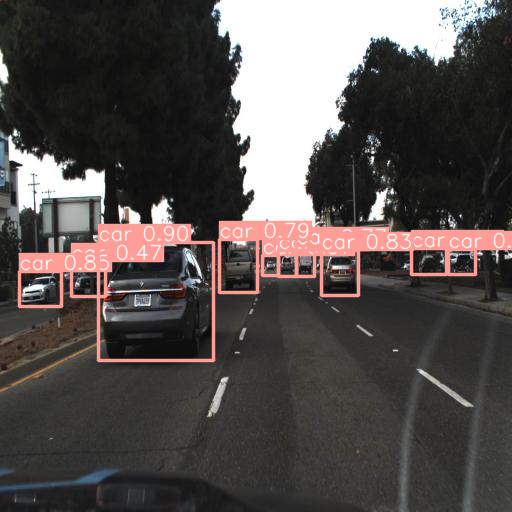

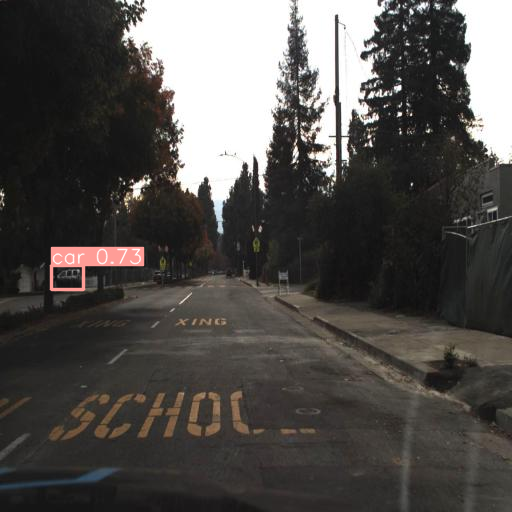

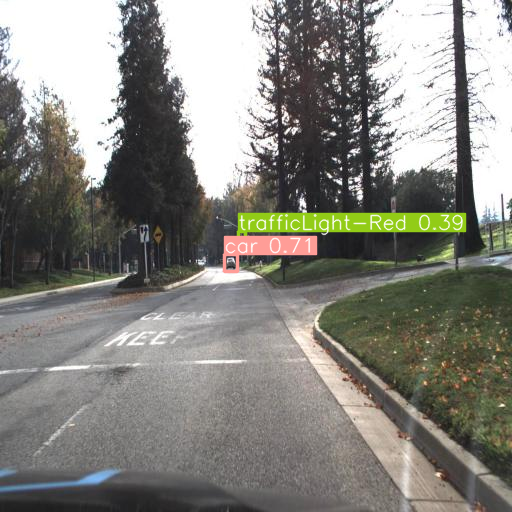

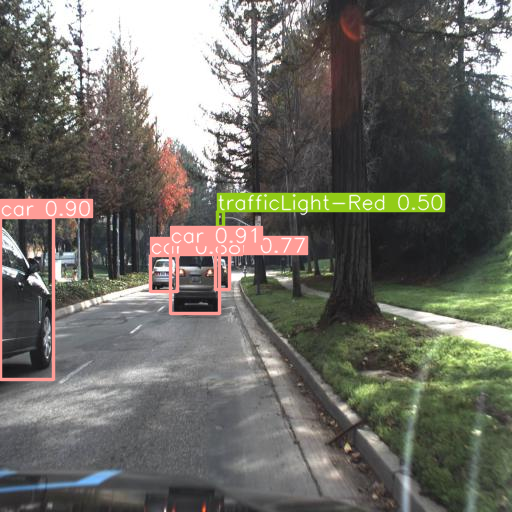

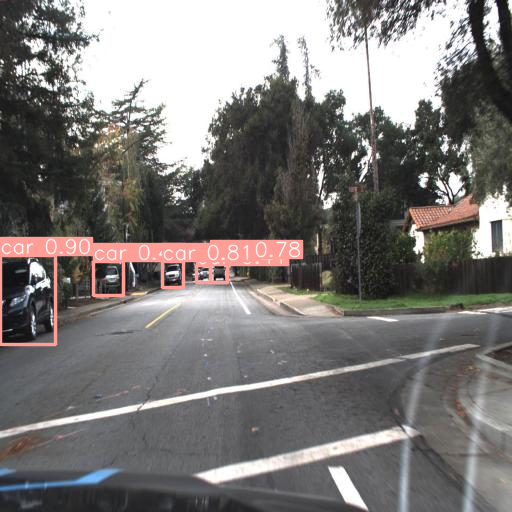

In [98]:
pred.show()

In [99]:
pred.pandas().xyxy

[         xmin        ymin        xmax        ymax  confidence  class name
 0   98.577400  242.602249  213.682861  360.717621    0.904728      1  car
 1   19.292212  271.563995   61.626842  306.285583    0.850002      1  car
 2  321.463470  250.360886  358.204407  295.329254    0.834199      1  car
 3  219.863525  239.148315  257.630707  292.659027    0.788565      1  car
 4  296.219391  245.224930  314.378662  276.490082    0.768465      1  car
 5  278.604492  250.206955  296.219482  276.229279    0.569868      1  car
 6  448.514618  249.691238  475.319489  274.636841    0.527893      1  car
 7   71.954216  261.378326  105.667618  296.317474    0.465603      1  car
 8  262.853577  255.003220  278.478088  275.722748    0.367027      1  car
 9  411.343994  248.049103  446.791962  274.378998    0.354849      1  car,
         xmin        ymin       xmax        ymax  confidence  class name
 0  51.041828  265.469757  83.299507  289.801788    0.725411      1  car,
          xmin        ymin 

In [100]:
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt


def show_val_image(img):
    pth = img.replace('/images/', '/labels/').replace('.jpg', '.txt')

    img = Image.open(img)
    with open(pth) as f:
      label = f.read()

    print(f'{img.size=}')
    width, height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)
    for line in label.split('\n'):
      cx, cy, w, h = map(float, line.split(' ')[1:])
      cx *= width
      cy *= height
      w *= width
      h *= height
      x = cx - w / 2
      y = cy - h / 2
      coor = [(x, y), (x + w, y), (x + w, y + h), (x, y + h), (x, y)]
      coor = np.array(coor)
      ax.plot(*coor.T)
    fig.show()



img.size=(512, 512)
img.size=(512, 512)
img.size=(512, 512)
img.size=(512, 512)
img.size=(512, 512)


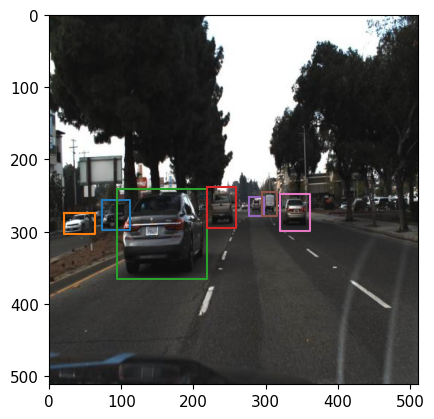

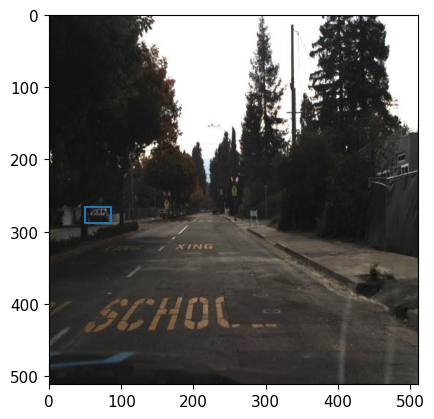

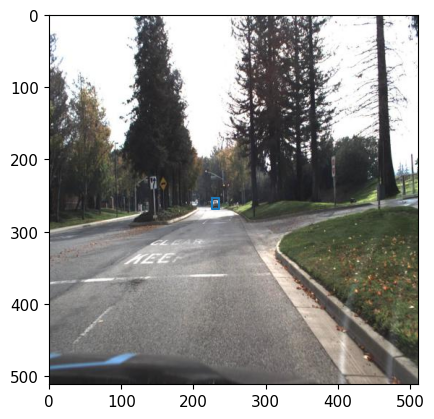

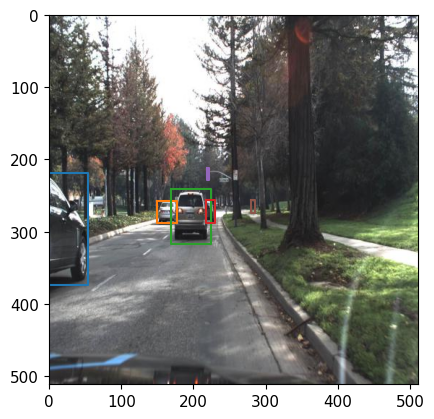

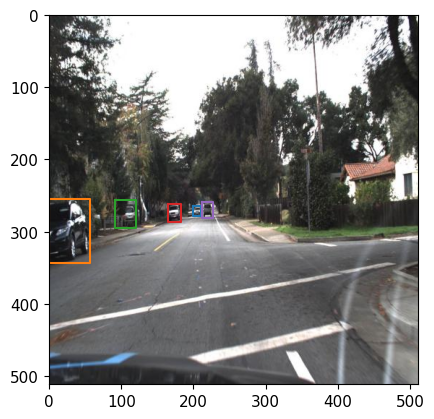

In [101]:
for img in pths:
    show_val_image(img)

In [88]:
torch.cuda.empty_cache()